In [15]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../')

In [572]:
import nets.cornet.cornet_r as CR
import nets.cornet.cornet_s as CS
import nets.cornet.cornet_z as CZ


import nets.cornet.cornet_z_regression as CZR
import nets.cornet.cornet_s_regression as CSR

In [564]:
import torch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.dataset import Dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


import sklearn.metrics

In [9]:
sys.path.append('../external/perception/EXP/ClevelandMcGill/')
import figure1

In [545]:
DATATYPE = figure1.Figure1.length

#
# DATA
#
train_target = 60000
val_target = 20000
test_target = 20000

# get global min and max
global_min = np.inf
global_max = -np.inf
for N in range(train_target+val_target+test_target):

    sparse, image, label, parameters = figure1.Figure1.length()

    global_min = min(label, global_min)
    global_max = max(label, global_max)
# end of global min max

# get the range and shuffle it.. just not the min and max since this will always be training data
labels_without_first_and_last = list(range(global_min+1, global_max))
label_count = len(labels_without_first_and_last)+2
np.random.shuffle(labels_without_first_and_last)

# assign target labels to train, val, and test data
train_target_labels = [global_min, global_max]
val_target_labels = []
test_target_labels = []

for i in range(int(label_count*.6) - 2):
    train_target_labels.append(labels_without_first_and_last.pop())
    
for i in range(int(label_count*.2)):
    val_target_labels.append(labels_without_first_and_last.pop())
    
for i in range(int(label_count*.2)):
    test_target_labels.append(labels_without_first_and_last.pop())

# make sure all 3 groups are unique
assert len(np.intersect1d(train_target_labels, val_target_labels)) == 0
assert len(np.intersect1d(train_target_labels, test_target_labels)) == 0
assert len(np.intersect1d(test_target_labels, val_target_labels)) == 0

#
# fill in the data
#
X_train = np.zeros((train_target, 100, 100), dtype=np.bool)
y_train = np.zeros((train_target), dtype=np.float32)
train_counter = 0

X_val = np.zeros((val_target, 100, 100), dtype=np.bool)
y_val = np.zeros((val_target), dtype=np.float32)
val_counter = 0

X_test = np.zeros((test_target, 100, 100), dtype=np.bool)
y_test = np.zeros((test_target), dtype=np.float32)
test_counter = 0

FLAGS = [False]*10
while train_counter < train_target:
    
    sparse, image, label, parameters = DATATYPE(FLAGS, preset=np.random.choice(train_target_labels))
    X_train[train_counter] = image
    y_train[train_counter] = label
    train_counter += 1
    
print('Training Parameters', parameters)
    
FLAGS = [True]*10
while val_counter < val_target:
    
    sparse, image, label, parameters = DATATYPE(FLAGS, preset=np.random.choice(val_target_labels))
    X_val[val_counter] = image
    y_val[val_counter] = label
    val_counter += 1
    
FLAGS = [True]*10
while test_counter < test_target:
    
    sparse, image, label, parameters = DATATYPE(FLAGS, preset=np.random.choice(test_target_labels))
    X_test[test_counter] = image
    y_test[test_counter] = label
    test_counter += 1
    
print('Testing Parameters', parameters)


Training Parameters 60
Testing Parameters 864000


In [546]:
#
#
# NORMALIZE DATA IN-PLACE (BUT SEPERATELY)
#
#
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

X_min = X_train.min()
X_max = X_train.max()
y_min = y_train.min()
y_max = y_train.max()

# scale in place
X_train -= X_min
X_train /= (X_max - X_min)
y_train -= y_min
y_train /= (y_max - y_min)

X_val -= X_min
X_val /= (X_max - X_min)
y_val -= y_min
y_val /= (y_max - y_min)

X_test -= X_min
X_test /= (X_max - X_min)
y_test -= y_min
y_test /= (y_max - y_min)

# normalize to -.5 .. .5
X_train -= .5
X_val -= .5
X_test -= .5


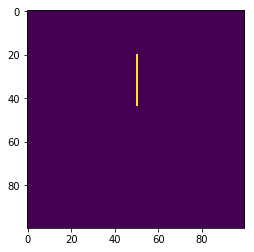

In [580]:
imshow(X_train[2314])

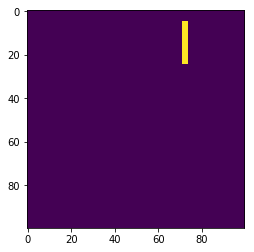

In [578]:
imshow(X_test[120])

In [548]:
X_train.shape, X_val.shape, X_test.shape

((60000, 100, 100), (20000, 100, 100), (20000, 100, 100))

In [549]:
#
# CREATE 3 CHANNELS
#
X_train_ = X_train.reshape(X_train.shape[0],1,X_train.shape[-2],X_train.shape[-1])
X_train_rgb = np.zeros((X_train.shape[0], 3, X_train.shape[-2], X_train.shape[-1]), dtype=X_train.dtype)
X_train_rgb[:,:,:,:] = X_train_

X_val_ = X_val.reshape(X_val.shape[0],1,X_val.shape[-2],X_val.shape[-1])
X_val_rgb = np.zeros((X_val.shape[0], 3, X_val.shape[-2], X_val.shape[-1]), dtype=X_val.dtype)
X_val_rgb[:,:,:,:] = X_val_

X_test_ = X_test.reshape(X_test.shape[0],1,X_test.shape[-2],X_test.shape[-1])
X_test_rgb = np.zeros((X_test.shape[0], 3, X_test.shape[-2], X_test.shape[-1]), dtype=X_test.dtype)
X_test_rgb[:,:,:,:] = X_test_

In [551]:
# reshape regression target
y_train_ = y_train.reshape(-1, 1)
y_val_ = y_val.reshape(-1, 1)
y_test_ = y_test.reshape(-1, 1)

In [565]:
Z = NeuralNetRegressor(
    CZR.CORnet_Z_Regression,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    train_split=predefined_split(Dataset(X_val_rgb, y_val_)),
    device='cuda'
)
Z.fit(X_train_rgb, y_train_);
y_pred = Z.predict(X_test_rgb)
# print('Test acc.:', np.mean(y_pred == y_test_))
print('Test MAE:', sklearn.metrics.mean_absolute_error(y_pred, y_test_))
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test_*100)+.125)
print('Test MLAE:', MLAE)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0744        0.1195  22.4485
      2        0.0278        0.1881  22.4933
      3        0.0056        0.2428  22.5461
      4        0.0033        0.2485  22.6191
      5        0.0025        0.2463  22.6741
      6        0.0019        0.2433  22.8085
      7        0.0015        0.2391  22.7929
      8        0.0011        0.2347  22.8478
      9        0.0009        0.2305  22.7648
     10        0.0006        0.2268  22.7803
     11        0.0005        0.2234  22.9589
     12        0.0004        0.2203  22.8354
     13        0.0003        0.2176  22.8953
     14        0.0002        0.2154  22.9013
     15        0.0002        0.2135  22.8524
     16        0.0001        0.2118  22.8773
     17        0.0001        0.2105  22.8458
     18        0.0001        0.2095  22.9113
     19        0.0001        0.2086  22.9744
     20        0.0001        0.2079  22.9815
     21   

In [574]:
S = NeuralNetRegressor(
    CSR.CORnet_S_Regression,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    train_split=predefined_split(Dataset(X_val_rgb, y_val_)),
    device='cuda'
)
S.fit(X_train_rgb, y_train_);
y_pred = S.predict(X_test_rgb)
# print('Test acc.:', np.mean(y_pred == y_test_))
print('Test MAE:', sklearn.metrics.mean_absolute_error(y_pred, y_test_))
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test_*100)+.125)
print('Test MLAE:', MLAE)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.0011       15.9672  495.6455
      2        0.0002       13.6742  497.0290
      3        0.0001       13.6325  496.8716
      4        0.0001       13.2963  496.8030
Test MAE: 2.687762
Test MLAE: 8.070932461507919


In [7]:
R = NeuralNetClassifier(
    CR.CORnet_R,
    max_epochs=30,
    lr=1e-3,
    batch_size=128,
    criterion=torch.nn.CrossEntropyLoss,
    device='cuda'
)

In [8]:
R.fit(X_train_rgb, y_train);
y_pred = R.predict(X_test_rgb)
print('Test acc.:', np.mean(y_pred == y_test))

RuntimeError: The size of tensor a (4) must match the size of tensor b (28) at non-singleton dimension 3

In [6]:
S = NeuralNetClassifier(
    CS.CORnet_S,
    max_epochs=30,
    lr=1e-3,
    batch_size=128,
    criterion=torch.nn.CrossEntropyLoss,
    device='cuda'
)


In [7]:
S.fit(X_train_rgb, y_train);
y_pred = S.predict(X_test_rgb)
print('Test acc.:', np.mean(y_pred == y_test))

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.7792       0.9251        0.3259  171.9588
      2        0.2155       0.9527        0.1741  171.9808
      3        0.1182       0.9613        0.1397  171.9605
Test acc.: 0.9594857142857143
